#2. Conjunto de datos

El conjunto de datos a utilizar contiene tres etiquetas: <u>Healthy</u> (saludable), <u>Powdery</u> (polvorienta) y <u>Rust</u> (oxidada) que hacen referencia a las condiciones de la planta. 
<br>
<table border="5">
<thead>
<tr>
<td><b>Healthy</b> / Saludable</td>
<td><b>Powdery</b> / Polvorienta</td>
<td><b>Rust</b> / Oxidada</td>
</tr>
</thead>
<tbody>
<tr>
<td><img src="https://github.com/JLopez86/plant_disease/blob/main/00-IMG/saludable.jpg" alt="Healthy" width="240" height="167" /></td>
<td><img src="https://github.com/JLopez86/plant_disease/blob/main/00-IMG/polvorienta.jpg" alt="Powdery" width="240" height="167" /></td>
<td><img src="https://github.com/JLopez86/plant_disease/blob/main/00-IMG/oxidada.jpg" alt="Rust" width="240" height="167" /></td>
</tr>
</tbody>
</table><br>

**Total de imágenes del conjunto de datos**

Hay un total de **1532** imágenes divididas en conjuntos de entrenamiento, prueba y validación. 

  **1472** imagenes para entrenamiento y validación. <br>
  **60** imágenes desconocidas por el modelo.

El conjunto de datos se encuentra disponible en el siguiente [enlace](https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset)

##2.1 Instalación de Requerimientos

In [ ]:
# Instalación de Kaggle
! pip install -q kaggle
# Actualización de Matplotlib
! pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 14.2 MB/s 
     |████████████████████████████████| 965 kB 87.0 MB/s 
     |████████████████████████████████| 295 kB 64.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Importación de librerías
from google.colab import files
from google.colab import drive
from fastai.vision.all import *
import os
import shutil
import torch
import random
#from fastai.callback.tensorboard import TensorBoardCallback
#from fastai.callback.hook import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib: {}'.format(matplotlib.__version__))

# Verificación de activación de GPU
print(torch.cuda.is_available())

matplotlib: 3.6.2
False


In [ ]:
# Montar el drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Es necesario crear un cuenta en Kaggle y posteriormente generar un API Token
# Carga de la credencial generada
files.upload()

In [ ]:
# Creamos una carpeta oculta en el sistema de archivos con el nombre .kaggle.
! mkdir ~/.kaggle
# Copiamos el archivo de credenciales que subimos en la carpeta que creamos previamente.
! cp kaggle.json ~/.kaggle/
# Cambiamos los permisos para permitir lectura de las credenciales.
! chmod 600 ~/.kaggle/kaggle.json
# Descargamos el dataset al Drive
! kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset
# Montamos el drive
#drive.mount('/content/drive/')
# Descomprimimos el conjunto de datos
! unzip -q /content/plant-disease-recognition-dataset.zip -d /content/dataset

100% 1.24G/1.25G [00:38<00:00, 34.6MB/s]
100% 1.25G/1.25G [00:38<00:00, 34.5MB/s]


In [ ]:
# Crear Directorios
! mkdir /content/Plant_Disease
! mkdir /content/Plant_Disease/Healthy
! mkdir /content/Plant_Disease/Powdery
! mkdir /content/Plant_Disease/Rust
! mkdir /content/models
# Paths para mover los archivos
sources = ['/content/dataset/Train/Train', '/content/dataset/Test/Test']
destinations = []
for etiq in os.listdir(sources[0]):
  destinations.append('/content/Plant_Disease/'+etiq)

In [ ]:
# Mover a el conjunto de datos a un directorio general
path = "/content/dataset"
for i in range(len(os.listdir(path))-1):
  directories =  os.listdir(sources[i])
  a = 0
  for directory in directories:  
    files = os.listdir(sources[i]+"/"+directory)
    for file in files:
      new_path = shutil.move(f"{sources[i]}/{directory}/{file}", destinations[a])
    a += 1

##2.2. Exploración del conjunto de datos

In [ ]:
# Cargar el dataset en memoria
path = "/content/Plant_Disease"
files = get_image_files(path)

In [ ]:
# Verificación del número de imágenes disponibles del dataset
print(f"Cantidad de imágenes disponibles en el dataset: {len(files)}")

Cantidad de imágenes disponibles en el dataset: 1472


Tamaño de la imagen es de (1728 x 2592) y de 3 canal/es


<AxesSubplot: >

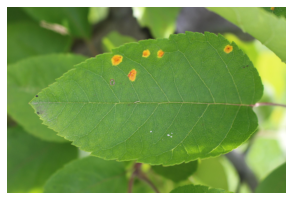

In [ ]:
# Visualización de un imagen al azar y su resolución
im = image2tensor(Image.open(str(files[random.randint(0, len(files)-1)])))
print(f"El tamaño de la imagen es de ({im.shape[1]} x {im.shape[2]}) y de {im.shape[0]} canal/es")
show_image(im)

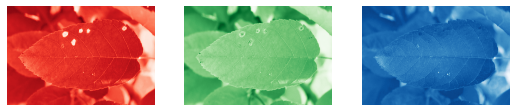

In [ ]:
# Visualización de los canales de la imagen al azar
_,axs = subplots(1,3)
for im,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-im, ax=ax, cmap=color)

Se redimensionan las imágenes del conjunto de datos con tamaño máximo de 600 pixeles
------------------------------------------------------------
Tamaño de la imagen es de (450 x 600) y de 3 canal/es


<AxesSubplot: >

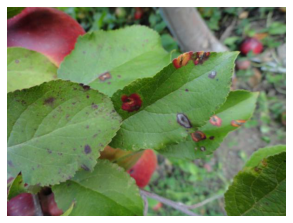

In [ ]:
# Redimensionar las imágenes
resize_path = 'Plant_Disease'
max_size = 600
resize_images(path, max_workers=2, max_size=max_size, recurse=True, dest=Path(resize_path), n_channels=3)
files = get_image_files(resize_path)

print(f"Se redimensionan las imágenes del conjunto de datos con tamaño máximo de {max_size} pixeles")
print("---"*20)
im = image2tensor(Image.open(str(files[random.randint(0, len(files)-1)])))
print(f"Tamaño de la imagen es de ({im.shape[1]} x {im.shape[2]}) y de {im.shape[0]} canal/es")
show_image(im)

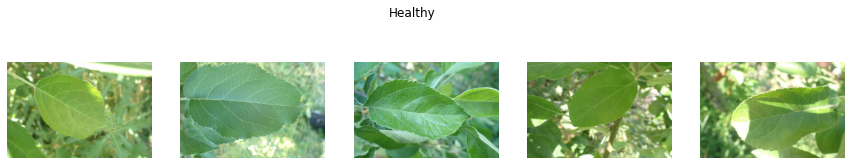

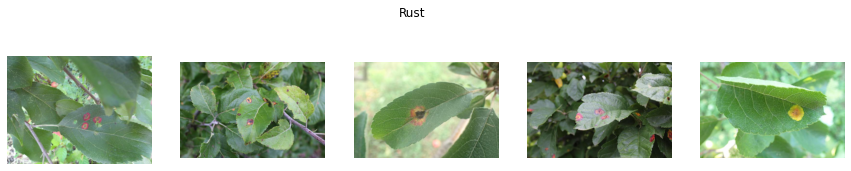

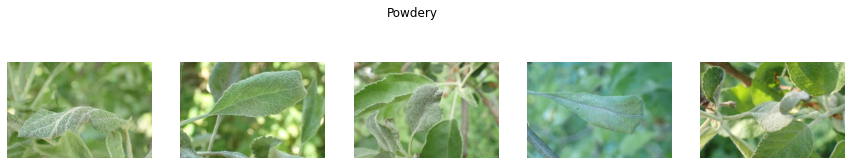

In [ ]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(resize_path)
dataset = {}
for label in labels:
  images = get_image_files(resize_path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

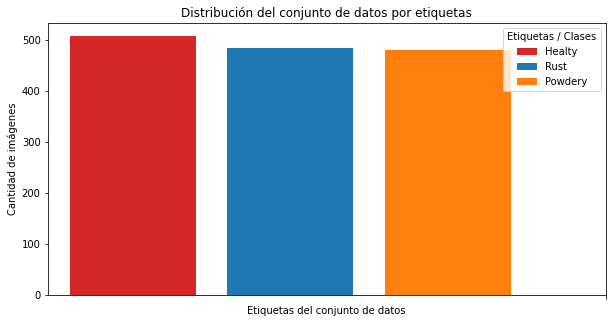

In [ ]:
# Verificar la distribución de clases dentro del dataset
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(range(len(dataset)), list(dataset.values()), align='center')
plt.xticks(range(len(dataset)), list(dataset.keys()))
bar_labels = ['Healty', 'Rust', 'Powdery']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(dataset.keys(), dataset.values(), label=bar_labels, color=bar_colors)

ax.set_ylabel('Cantidad de imágenes')
ax.set_xlabel('Etiquetas del conjunto de datos')
ax.set_xticks(str(dataset.values()))
ax.set_title('Distribución del conjunto de datos por etiquetas')
ax.legend(title='Etiquetas / Clases')

plt.show()

##2.3. Exportar conjunto de datos al drive

In [ ]:
! pwd

/content


In [ ]:
# Comprimir conjunto de datos
! zip -r Plant_Disease.zip ./Plant_Disease 

  adding: Plant_Disease/ (stored 0%)
  adding: Plant_Disease/Healthy/ (stored 0%)
  adding: Plant_Disease/Healthy/94b531898979f38b.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/97f3cad16524509b.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/83f7381b7cace01c.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/86c8358db7d560ad.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/8e6a823cce9ff40c.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/85edd994308a6f65.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/84f60a857fb26bc1.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/818a15d52bb75f0e.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/9f2174f703ca3961.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/88d8c872ceb7a2b6.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/90c790666f674f58.jpg (deflated 1%)
  adding: Plant_Disease/Healthy/93a7c1dd2fe04f20.jpg (deflated 0%)
  adding: Plant_Disease/Healthy/98d2ed0b33c866d9.jpg (deflated 0%)
  adding: Plant_Disease/Healthy/8bda74e18b458f0

In [ ]:
# Se mueve el archivo zip a la ruta prevista en el drive
! mv Plant_Disease.zip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas

In [ ]:
# Comprimir conjunto de datos
! zip -r Plant_Disease.zip ./dataset/Validation/Validation

  adding: dataset/Validation/Validation/ (stored 0%)
  adding: dataset/Validation/Validation/Healthy/ (stored 0%)
  adding: dataset/Validation/Validation/Healthy/9c3684213b2f0fdd.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9cb09eb2cabfc700.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9c99786a63786571.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9cc33c23b0df68b2.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9d6a6499354e3197.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9c077ad23a231abb.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9cd0cc3176c4fad1.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9bd4cc8c52e9d52a.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg (deflated 2%)
  adding: dataset/Validation/Validation/Healthy/9be561de7c792420.jpg (deflated 1%)
  adding: dataset/Validation/Validation/Healthy/9ccf7089